STEP 4: Improve Performance (Optional but recommended

In [1]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Accuracy Plot

Loss Plot

Predictions

In [53]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### RESNET 18

In [2]:
pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## LELEK

# ingfso


In [118]:
base_dir = "/content/drive/MyDrive/Resnet18Datset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Check class distribution
labels_list = [label for _, label in train_dataset.samples]
class_distribution = Counter(labels_list)
print("Class distribution:")
for class_idx, count in class_distribution.items():
    class_name = train_dataset.classes[class_idx]
    print(f"  {class_name} (index {class_idx}): {count} samples")


Class distribution:
  kurang sehat (index 0): 110 samples
  sehat (index 1): 115 samples


In [119]:
class ImprovedFocalLoss(nn.Module):
    def __init__(self, alpha=2.0, gamma=2.0, weight=None):
        super(ImprovedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [120]:
def create_balanced_sampler(dataset):
    """Create a sampler that gives higher weight to minority class"""
    labels = [sample[1] for sample in dataset.samples]
    class_counts = np.bincount(labels)

    # Calculate weights - higher for minority class
    weights = []
    for label in labels:
        if label == 0:  # kurang sehat (minority class)
            weights.append(1.0 / class_counts[label] * 1.5)  # Extra boost
        else:  # sehat
            weights.append(1.0 / class_counts[label])

    return WeightedRandomSampler(
        weights=weights,
        num_samples=len(weights),
        replacement=True
    )

In [138]:
def evaluate_with_threshold(model, data_loader, device, threshold=0.5):
    """Evaluate model with custom threshold"""
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Apply threshold
    predictions = (all_probs[:, 1] > threshold).astype(int)



    # Calculate metrics
    accuracy = (predictions == all_labels).mean()

    # Per-class accuracy
    kurang_sehat_mask = all_labels == 0
    sehat_mask = all_labels == 1

    kurang_sehat_acc = (predictions[kurang_sehat_mask] == all_labels[kurang_sehat_mask]).mean() if kurang_sehat_mask.sum() > 0 else 0
    sehat_acc = (predictions[sehat_mask] == all_labels[sehat_mask]).mean() if sehat_mask.sum() > 0 else 0

    return accuracy, kurang_sehat_acc, sehat_acc, predictions

In [139]:
def calculate_balanced_accuracy(y_true, y_pred):
    """Calculate balanced accuracy (average of per-class accuracies)"""
    class_accuracies = []
    for class_idx in range(2):
        mask = y_true == class_idx
        if mask.sum() > 0:
            class_acc = (y_pred[mask] == y_true[mask]).mean()
            class_accuracies.append(class_acc)
    return np.mean(class_accuracies)

In [140]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter


In [141]:
balanced_sampler = create_balanced_sampler(train_dataset)

# Create data loaders
balanced_train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=balanced_sampler  # Use balanced sampler instead of shuffle
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze early layers, unfreeze later layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last few layers
for name, param in list(model.named_parameters())[-8:]:
    param.requires_grad = True
    print(f"Unfrozen: {name}")

# Replace classifier
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Better weight initialization
nn.init.xavier_uniform_(model.fc.weight)
nn.init.zeros_(model.fc.bias)

model = model.to(device)

Using device: cuda
Unfrozen: layer4.1.conv1.weight
Unfrozen: layer4.1.bn1.weight
Unfrozen: layer4.1.bn1.bias
Unfrozen: layer4.1.conv2.weight
Unfrozen: layer4.1.bn2.weight
Unfrozen: layer4.1.bn2.bias
Unfrozen: fc.weight
Unfrozen: fc.bias


In [146]:
class_weights = torch.tensor([2.5, 1.0], dtype=torch.float).to(device)
criterion = ImprovedFocalLoss(alpha=2.0, gamma=2.0, weight=class_weights)

# Different learning rates for different layers
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': 0.001},  # Higher LR for new layer
    {'params': [p for n, p in model.named_parameters() if 'fc' not in n and p.requires_grad], 'lr': 0.0001}  # Lower LR for pretrained layers
])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [147]:
num_epochs = 25
best_balanced_acc = 0.0
patience = 7
patience_counter = 0

print("Starting training with all improvements...")
print("=" * 60)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for inputs, labels in tqdm(balanced_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Training metrics
    train_loss = running_loss / len(balanced_train_loader)
    train_acc = np.mean(np.array(train_preds) == np.array(train_labels))
    train_balanced_acc = calculate_balanced_accuracy(np.array(train_labels), np.array(train_preds))

    # Validation phase
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    val_balanced_acc = calculate_balanced_accuracy(np.array(val_labels), np.array(val_preds))

    # Per-class accuracies
    print(f"Epoch {epoch+1} Results:")
    for class_idx in range(2):
        class_name = train_dataset.classes[class_idx]

        # Training
        train_mask = np.array(train_labels) == class_idx
        train_class_acc = np.mean(np.array(train_preds)[train_mask] == np.array(train_labels)[train_mask]) if train_mask.sum() > 0 else 0

        # Validation
        val_mask = np.array(val_labels) == class_idx
        val_class_acc = np.mean(np.array(val_preds)[val_mask] == np.array(val_labels)[val_mask]) if val_mask.sum() > 0 else 0

        print(f"  {class_name} - Train: {train_class_acc:.4f}, Val: {val_class_acc:.4f}")

    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Balanced: {train_balanced_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Balanced: {val_balanced_acc:.4f}")

    # Step scheduler
    scheduler.step(val_balanced_acc)

    # Save best model
    if val_balanced_acc > best_balanced_acc:
        best_balanced_acc = val_balanced_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_balanced_model.pth')
        print(f"  ⭐ New best balanced accuracy: {best_balanced_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print confusion matrix every 5 epochs
    if (epoch + 1) % 5 == 0:
        cm = confusion_matrix(val_labels, val_preds)
        print(f"  Confusion Matrix: [[{cm[0,0]}, {cm[0,1]}], [{cm[1,0]}, {cm[1,1]}]]")
        kurang_sehat_recall = cm[0,0]/(cm[0,0]+cm[0,1]) if (cm[0,0]+cm[0,1]) > 0 else 0
        sehat_recall = cm[1,1]/(cm[1,0]+cm[1,1]) if (cm[1,0]+cm[1,1]) > 0 else 0
        print(f"  Kurang Sehat Recall: {kurang_sehat_recall:.4f}, Sehat Recall: {sehat_recall:.4f}")

    print("-" * 60)

print(f"Training completed! Best balanced accuracy: {best_balanced_acc:.4f}")

Starting training with all improvements...


Epoch 1/25: 100%|██████████| 8/8 [00:01<00:00,  6.56it/s]


Epoch 1 Results:
  kurang sehat - Train: 0.9259, Val: 1.0000
  sehat - Train: 0.9333, Val: 0.9231
  Train Loss: 0.3551, Train Acc: 0.9289, Train Balanced: 0.9296
  Val Loss: 0.0859, Val Acc: 0.9592, Val Balanced: 0.9615
  ⭐ New best balanced accuracy: 0.9615
------------------------------------------------------------


Epoch 2/25: 100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Epoch 2 Results:
  kurang sehat - Train: 0.9841, Val: 1.0000
  sehat - Train: 0.9192, Val: 0.8846
  Train Loss: 0.0571, Train Acc: 0.9556, Train Balanced: 0.9517
  Val Loss: 0.2132, Val Acc: 0.9388, Val Balanced: 0.9423
------------------------------------------------------------


Epoch 3/25: 100%|██████████| 8/8 [00:01<00:00,  5.84it/s]


Epoch 3 Results:
  kurang sehat - Train: 1.0000, Val: 1.0000
  sehat - Train: 0.9146, Val: 0.8077
  Train Loss: 0.8273, Train Acc: 0.9689, Train Balanced: 0.9573
  Val Loss: 0.2489, Val Acc: 0.8980, Val Balanced: 0.9038
------------------------------------------------------------


Epoch 4/25: 100%|██████████| 8/8 [00:01<00:00,  5.69it/s]


Epoch 4 Results:
  kurang sehat - Train: 1.0000, Val: 0.8696
  sehat - Train: 0.9878, Val: 0.9615
  Train Loss: 0.0194, Train Acc: 0.9956, Train Balanced: 0.9939
  Val Loss: 0.1576, Val Acc: 0.9184, Val Balanced: 0.9156
------------------------------------------------------------


Epoch 5/25: 100%|██████████| 8/8 [00:01<00:00,  6.63it/s]


Epoch 5 Results:
  kurang sehat - Train: 0.9928, Val: 0.7391
  sehat - Train: 1.0000, Val: 1.0000
  Train Loss: 0.0689, Train Acc: 0.9956, Train Balanced: 0.9964
  Val Loss: 0.2638, Val Acc: 0.8776, Val Balanced: 0.8696
  Confusion Matrix: [[17, 6], [0, 26]]
  Kurang Sehat Recall: 0.7391, Sehat Recall: 1.0000
------------------------------------------------------------


Epoch 6/25: 100%|██████████| 8/8 [00:01<00:00,  6.56it/s]


Epoch 6 Results:
  kurang sehat - Train: 1.0000, Val: 0.7826
  sehat - Train: 1.0000, Val: 1.0000
  Train Loss: 0.0246, Train Acc: 1.0000, Train Balanced: 1.0000
  Val Loss: 0.2509, Val Acc: 0.8980, Val Balanced: 0.8913
------------------------------------------------------------


Epoch 7/25: 100%|██████████| 8/8 [00:01<00:00,  6.57it/s]


Epoch 7 Results:
  kurang sehat - Train: 1.0000, Val: 0.8261
  sehat - Train: 0.9884, Val: 1.0000
  Train Loss: 0.1724, Train Acc: 0.9956, Train Balanced: 0.9942
  Val Loss: 0.1509, Val Acc: 0.9184, Val Balanced: 0.9130
------------------------------------------------------------


Epoch 8/25: 100%|██████████| 8/8 [00:01<00:00,  6.55it/s]


Epoch 8 Results:
  kurang sehat - Train: 1.0000, Val: 0.7391
  sehat - Train: 1.0000, Val: 1.0000
  Train Loss: 0.0547, Train Acc: 1.0000, Train Balanced: 1.0000
  Val Loss: 0.3188, Val Acc: 0.8776, Val Balanced: 0.8696
Early stopping at epoch 8
Training completed! Best balanced accuracy: 0.9615


In [148]:
print("\n" + "=" * 60)
print("FINAL EVALUATION WITH THRESHOLD TUNING")
print("=" * 60)

# Load best model
model.load_state_dict(torch.load('best_balanced_model.pth'))

# Test different thresholds
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
best_threshold = 0.5
best_kurang_sehat_acc = 0

print("Testing different thresholds:")
for threshold in thresholds:
    acc, ks_acc, s_acc, preds = evaluate_with_threshold(model, val_loader, device, threshold)
    print(f"  Threshold {threshold:.2f}: Overall: {acc:.4f}, Kurang Sehat: {ks_acc:.4f}, Sehat: {s_acc:.4f}")

    if ks_acc > best_kurang_sehat_acc:
        best_kurang_sehat_acc = ks_acc
        best_threshold = threshold

print(f"\n🎯 BEST THRESHOLD: {best_threshold:.2f}")
print(f"🎯 BEST KURANG SEHAT ACCURACY: {best_kurang_sehat_acc:.4f}")

# Final evaluation with best threshold
final_acc, final_ks_acc, final_s_acc, final_preds = evaluate_with_threshold(model, val_loader, device, best_threshold)
print(f"\nFINAL RESULTS WITH OPTIMIZED THRESHOLD:")
print(f"  Overall Accuracy: {final_acc:.4f}")
print(f"  Kurang Sehat Accuracy: {final_ks_acc:.4f}")
print(f"  Sehat Accuracy: {final_s_acc:.4f}")

# Final confusion matrix
val_labels_final = [label for _, label in val_dataset.samples]
cm_final = confusion_matrix(val_labels_final, final_preds)
print(f"\nFinal Confusion Matrix:")
print(f"  [[{cm_final[0,0]}, {cm_final[0,1]}],")
print(f"   [{cm_final[1,0]}, {cm_final[1,1]}]]")

print(f"\nTRAINING SUMMARY:")
print(f"  ✅ Used balanced sampling")
print(f"  ✅ Used focal loss with class weights")
print(f"  ✅ Used different learning rates")
print(f"  ✅ Optimized threshold for kurang sehat detection")
print(f"  ✅ Best threshold: {best_threshold}")


FINAL EVALUATION WITH THRESHOLD TUNING
Testing different thresholds:
  Threshold 0.30: Overall: 0.9592, Kurang Sehat: 0.9565, Sehat: 0.9615
  Threshold 0.35: Overall: 0.9388, Kurang Sehat: 0.9565, Sehat: 0.9231
  Threshold 0.40: Overall: 0.9388, Kurang Sehat: 0.9565, Sehat: 0.9231
  Threshold 0.45: Overall: 0.9592, Kurang Sehat: 1.0000, Sehat: 0.9231
  Threshold 0.50: Overall: 0.9592, Kurang Sehat: 1.0000, Sehat: 0.9231
  Threshold 0.55: Overall: 0.9592, Kurang Sehat: 1.0000, Sehat: 0.9231
  Threshold 0.60: Overall: 0.9592, Kurang Sehat: 1.0000, Sehat: 0.9231

🎯 BEST THRESHOLD: 0.45
🎯 BEST KURANG SEHAT ACCURACY: 1.0000

FINAL RESULTS WITH OPTIMIZED THRESHOLD:
  Overall Accuracy: 0.9592
  Kurang Sehat Accuracy: 1.0000
  Sehat Accuracy: 0.9231

Final Confusion Matrix:
  [[23, 0],
   [2, 24]]

TRAINING SUMMARY:
  ✅ Used balanced sampling
  ✅ Used focal loss with class weights
  ✅ Used different learning rates
  ✅ Optimized threshold for kurang sehat detection
  ✅ Best threshold: 0.45


In [94]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Directory setup
base_dir = "/content/drive/MyDrive/Resnet18Datset"  # adjust if needed
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)


# After loading train_dataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

labels_list = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_list),
    y=labels_list
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", weights_tensor)

# Then when defining loss:
criterion = nn.CrossEntropyLoss(weight=weights_tensor)


# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes
print(class_names)


Class weights: tensor([1.0227, 0.9783], device='cuda:0')
['kurang sehat', 'sehat']


In [110]:
import torch
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Check actual class distribution
labels_list = [label for _, label in train_dataset.samples]
class_distribution = Counter(labels_list)
print("Class distribution:")
for class_idx, count in class_distribution.items():
    class_name = train_dataset.classes[class_idx]
    print(f"  {class_name} (index {class_idx}): {count} samples")

# Verify class weights calculation
print(f"\nClass names: {train_dataset.classes}")
print(f"Class indices: {np.unique(labels_list)}")

# Alternative way to compute class weights
total_samples = len(labels_list)
n_classes = len(train_dataset.classes)
class_weights_manual = []

for class_idx in range(n_classes):
    class_count = class_distribution[class_idx]
    weight = total_samples / (n_classes * class_count)
    class_weights_manual.append(weight)

print(f"Manual class weights: {class_weights_manual}")
print(f"Original class weights: {class_weights}")

# Check if weights are properly ordered
print(f"\nWeight for 'kurang sehat' (index 0): {class_weights[0]}")
print(f"Weight for 'sehat' (index 1): {class_weights[1]}")

Class distribution:
  kurang sehat (index 0): 110 samples
  sehat (index 1): 115 samples

Class names: ['kurang sehat', 'sehat']
Class indices: [0 1]
Manual class weights: [1.0227272727272727, 0.9782608695652174]
Original class weights: [1.02272727 0.97826087]

Weight for 'kurang sehat' (index 0): 1.0227272727272727
Weight for 'sehat' (index 1): 0.9782608695652174


In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


test model architecture

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Improved model setup
model = models.resnet18(weights='IMAGENET1K_V1')

# Option 1: Fine-tune last few layers (recommended for small datasets)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last few layers
for name, param in list(model.named_parameters())[-6:]:  # Adjust as needed
    param.requires_grad = True
    print(f"Unfrozen: {name}")

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move to device
model = model.to(device)

# Improved loss and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training with better monitoring
num_epochs = 20
best_val_acc = 0.0
patience = 5
patience_counter = 0

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    scheduler.step()

    # Calculate training metrics
    epoch_loss = running_loss / len(train_loader)
    train_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    train_losses.append(epoch_loss)

    # Print per-class training accuracy
    train_class_acc = []
    for class_idx in range(len(train_dataset.classes)):
        mask = np.array(all_labels) == class_idx
        if mask.sum() > 0:
            class_acc = np.mean(np.array(all_preds)[mask] == np.array(all_labels)[mask])
            train_class_acc.append(class_acc)
            print(f"Train {train_dataset.classes[class_idx]} accuracy: {class_acc:.4f}")

    print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation phase
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
    val_loss = val_loss / len(val_loader)
    val_accuracies.append(val_acc)

    # Print per-class validation accuracy
    print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
    for class_idx in range(len(train_dataset.classes)):
        mask = np.array(val_labels) == class_idx
        if mask.sum() > 0:
            class_acc = np.mean(np.array(val_preds)[mask] == np.array(val_labels)[mask])
            print(f"Val {train_dataset.classes[class_idx]} accuracy: {class_acc:.4f}")

    # Print confusion matrix every 5 epochs
    if (epoch + 1) % 5 == 0:
        cm = confusion_matrix(val_labels, val_preds)
        print(f"\nConfusion Matrix (Epoch {epoch+1}):")
        print(cm)
        print(f"True kurang sehat predicted as kurang sehat: {cm[0,0]}")
        print(f"True kurang sehat predicted as sehat: {cm[0,1]}")
        print(f"True sehat predicted as kurang sehat: {cm[1,0]}")
        print(f"True sehat predicted as sehat: {cm[1,1]}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print("-" * 50)

print(f"Best validation accuracy: {best_val_acc:.4f}")

Unfrozen: layer4.1.bn1.bias
Unfrozen: layer4.1.conv2.weight
Unfrozen: layer4.1.bn2.weight
Unfrozen: layer4.1.bn2.bias
Unfrozen: fc.weight
Unfrozen: fc.bias


Epoch 1/20: 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]


Train kurang sehat accuracy: 0.7909
Train sehat accuracy: 0.4348
Epoch 1: Train Loss: 0.6692, Train Acc: 0.6089
Validation Loss: 0.4835, Validation Acc: 0.7755
Val kurang sehat accuracy: 0.5217
Val sehat accuracy: 1.0000
--------------------------------------------------


Epoch 2/20: 100%|██████████| 8/8 [00:01<00:00,  6.69it/s]


Train kurang sehat accuracy: 0.8545
Train sehat accuracy: 0.8087
Epoch 2: Train Loss: 0.4403, Train Acc: 0.8311
Validation Loss: 0.3208, Validation Acc: 0.8367
Val kurang sehat accuracy: 0.6522
Val sehat accuracy: 1.0000
--------------------------------------------------


Epoch 3/20: 100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Train kurang sehat accuracy: 0.8000
Train sehat accuracy: 0.8957
Epoch 3: Train Loss: 0.3620, Train Acc: 0.8489
Validation Loss: 0.2330, Validation Acc: 0.9388
Val kurang sehat accuracy: 0.8696
Val sehat accuracy: 1.0000
--------------------------------------------------


Epoch 4/20: 100%|██████████| 8/8 [00:01<00:00,  6.11it/s]


Train kurang sehat accuracy: 0.8000
Train sehat accuracy: 0.9565
Epoch 4: Train Loss: 0.4096, Train Acc: 0.8800
Validation Loss: 0.2051, Validation Acc: 0.9388
Val kurang sehat accuracy: 0.8696
Val sehat accuracy: 1.0000
--------------------------------------------------


Epoch 5/20: 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


Train kurang sehat accuracy: 0.9273
Train sehat accuracy: 0.9217
Epoch 5: Train Loss: 0.2855, Train Acc: 0.9244
Validation Loss: 0.1743, Validation Acc: 0.9184
Val kurang sehat accuracy: 0.8696
Val sehat accuracy: 0.9615

Confusion Matrix (Epoch 5):
[[20  3]
 [ 1 25]]
True kurang sehat predicted as kurang sehat: 20
True kurang sehat predicted as sehat: 3
True sehat predicted as kurang sehat: 1
True sehat predicted as sehat: 25
--------------------------------------------------


Epoch 6/20: 100%|██████████| 8/8 [00:01<00:00,  6.71it/s]


Train kurang sehat accuracy: 0.9636
Train sehat accuracy: 0.9739
Epoch 6: Train Loss: 0.2482, Train Acc: 0.9689
Validation Loss: 0.1728, Validation Acc: 0.9184
Val kurang sehat accuracy: 0.9130
Val sehat accuracy: 0.9231
--------------------------------------------------


Epoch 7/20: 100%|██████████| 8/8 [00:01<00:00,  6.78it/s]


Train kurang sehat accuracy: 0.9364
Train sehat accuracy: 0.9652
Epoch 7: Train Loss: 0.2477, Train Acc: 0.9511
Validation Loss: 0.1712, Validation Acc: 0.9184
Val kurang sehat accuracy: 0.8696
Val sehat accuracy: 0.9615
--------------------------------------------------


Epoch 8/20: 100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Train kurang sehat accuracy: 0.9000
Train sehat accuracy: 0.9739
Epoch 8: Train Loss: 0.2716, Train Acc: 0.9378
Validation Loss: 0.1844, Validation Acc: 0.9184
Val kurang sehat accuracy: 0.9565
Val sehat accuracy: 0.8846
Early stopping at epoch 8
Best validation accuracy: 0.9388


Analyzing training data...

=== Training Analysis ===
Raw output statistics:
  Class 0 (kurang sehat) logits - Mean: -0.4698, Std: 0.8723
  Class 1 (sehat) logits - Mean: 0.0573, Std: 0.9143

Probability statistics:
  Class 0 (kurang sehat) probs - Mean: 0.4299, Std: 0.2816
  Class 1 (sehat) probs - Mean: 0.5701, Std: 0.2816

Prediction distribution:
  Predicted kurang sehat: 98 (43.6%)
  Predicted sehat: 127 (56.4%)

Actual label distribution:
  Actual kurang sehat: 110 (48.9%)
  Actual sehat: 115 (51.1%)

Confidence analysis:
  kurang sehat confidence - Mean: 0.6592, Min: 0.1913, Max: 0.9644
  sehat confidence - Mean: 0.7894, Min: 0.3040, Max: 0.9950

Kurang sehat probability distribution:
  Min: 0.0050
  Max: 0.9644
  Samples with >0.5 prob for kurang sehat: 98
  Samples with >0.7 prob for kurang sehat: 50
  Samples with >0.9 prob for kurang sehat: 6

Analyzing validation data...

=== Validation Analysis ===
Raw output statistics:
  Class 0 (kurang sehat) logits - Mean: -0.6162, Std

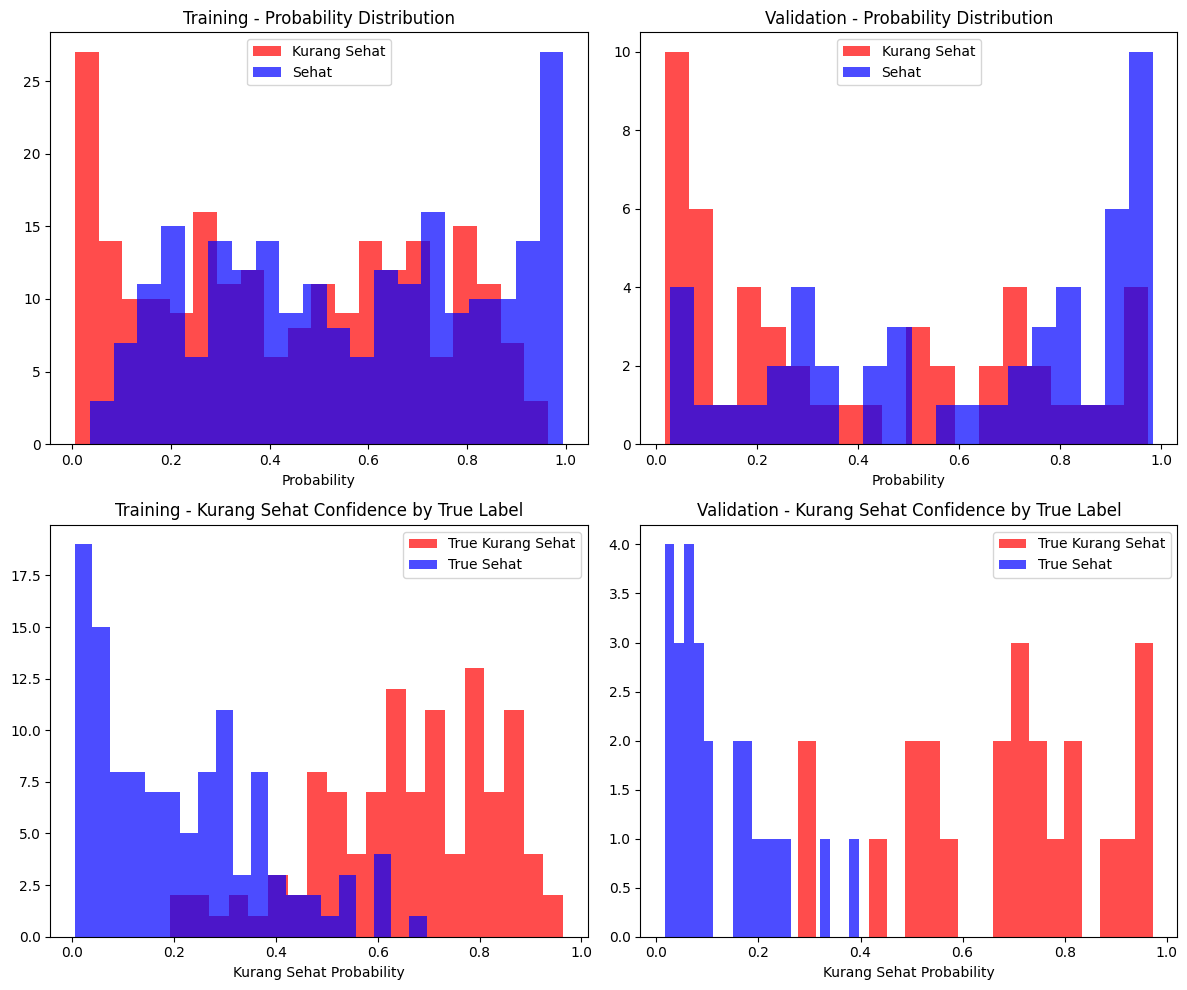

In [117]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def analyze_model_predictions(model, data_loader, device, dataset_name=""):
    """Analyze model predictions and output distributions"""
    model.eval()

    all_outputs = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get probabilities
            probs = F.softmax(outputs, dim=1)

            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    print(f"\n=== {dataset_name} Analysis ===")

    # 1. Check raw output distribution
    print("Raw output statistics:")
    print(f"  Class 0 (kurang sehat) logits - Mean: {all_outputs[:, 0].mean():.4f}, Std: {all_outputs[:, 0].std():.4f}")
    print(f"  Class 1 (sehat) logits - Mean: {all_outputs[:, 1].mean():.4f}, Std: {all_outputs[:, 1].std():.4f}")

    # 2. Check probability distribution
    print("\nProbability statistics:")
    print(f"  Class 0 (kurang sehat) probs - Mean: {all_probs[:, 0].mean():.4f}, Std: {all_probs[:, 0].std():.4f}")
    print(f"  Class 1 (sehat) probs - Mean: {all_probs[:, 1].mean():.4f}, Std: {all_probs[:, 1].std():.4f}")

    # 3. Check prediction distribution
    predictions = np.argmax(all_probs, axis=1)
    pred_counts = np.bincount(predictions)
    print(f"\nPrediction distribution:")
    print(f"  Predicted kurang sehat: {pred_counts[0]} ({pred_counts[0]/len(predictions)*100:.1f}%)")
    if len(pred_counts) > 1:
        print(f"  Predicted sehat: {pred_counts[1]} ({pred_counts[1]/len(predictions)*100:.1f}%)")

    # 4. Check actual label distribution
    label_counts = np.bincount(all_labels)
    print(f"\nActual label distribution:")
    print(f"  Actual kurang sehat: {label_counts[0]} ({label_counts[0]/len(all_labels)*100:.1f}%)")
    if len(label_counts) > 1:
        print(f"  Actual sehat: {label_counts[1]} ({label_counts[1]/len(all_labels)*100:.1f}%)")

    # 5. Check confidence for each class
    print(f"\nConfidence analysis:")
    for class_idx in range(2):
        class_mask = all_labels == class_idx
        if class_mask.sum() > 0:
            class_probs = all_probs[class_mask, class_idx]
            print(f"  {train_dataset.classes[class_idx]} confidence - Mean: {class_probs.mean():.4f}, Min: {class_probs.min():.4f}, Max: {class_probs.max():.4f}")

    # 6. Find samples with highest/lowest confidence for minority class
    kurang_sehat_probs = all_probs[:, 0]
    print(f"\nKurang sehat probability distribution:")
    print(f"  Min: {kurang_sehat_probs.min():.4f}")
    print(f"  Max: {kurang_sehat_probs.max():.4f}")
    print(f"  Samples with >0.5 prob for kurang sehat: {(kurang_sehat_probs > 0.5).sum()}")
    print(f"  Samples with >0.7 prob for kurang sehat: {(kurang_sehat_probs > 0.7).sum()}")
    print(f"  Samples with >0.9 prob for kurang sehat: {(kurang_sehat_probs > 0.9).sum()}")

    return all_outputs, all_labels, all_probs

# Run analysis
print("Analyzing training data...")
train_outputs, train_labels, train_probs = analyze_model_predictions(model, train_loader, device, "Training")

print("\nAnalyzing validation data...")
val_outputs, val_labels, val_probs = analyze_model_predictions(model, val_loader, device, "Validation")

# Plot probability distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Training data
axes[0, 0].hist(train_probs[:, 0], bins=20, alpha=0.7, color='red', label='Kurang Sehat')
axes[0, 0].hist(train_probs[:, 1], bins=20, alpha=0.7, color='blue', label='Sehat')
axes[0, 0].set_title('Training - Probability Distribution')
axes[0, 0].set_xlabel('Probability')
axes[0, 0].legend()

# Validation data
axes[0, 1].hist(val_probs[:, 0], bins=20, alpha=0.7, color='red', label='Kurang Sehat')
axes[0, 1].hist(val_probs[:, 1], bins=20, alpha=0.7, color='blue', label='Sehat')
axes[0, 1].set_title('Validation - Probability Distribution')
axes[0, 1].set_xlabel('Probability')
axes[0, 1].legend()

# Kurang sehat confidence by true label
kurang_sehat_true_mask = train_labels == 0
sehat_true_mask = train_labels == 1

axes[1, 0].hist(train_probs[kurang_sehat_true_mask, 0], bins=20, alpha=0.7, color='red', label='True Kurang Sehat')
axes[1, 0].hist(train_probs[sehat_true_mask, 0], bins=20, alpha=0.7, color='blue', label='True Sehat')
axes[1, 0].set_title('Training - Kurang Sehat Confidence by True Label')
axes[1, 0].set_xlabel('Kurang Sehat Probability')
axes[1, 0].legend()

# Same for validation
kurang_sehat_true_mask_val = val_labels == 0
sehat_true_mask_val = val_labels == 1

axes[1, 1].hist(val_probs[kurang_sehat_true_mask_val, 0], bins=20, alpha=0.7, color='red', label='True Kurang Sehat')
axes[1, 1].hist(val_probs[sehat_true_mask_val, 0], bins=20, alpha=0.7, color='blue', label='True Sehat')
axes[1, 1].set_title('Validation - Kurang Sehat Confidence by True Label')
axes[1, 1].set_xlabel('Kurang Sehat Probability')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [91]:
import torch.nn as nn
import torchvision.models as models

# Load pretrained model
model = models.resnet18(weights='IMAGENET1K_V1')

# 🔒 Freeze all layers first
# for param in model.parameters():
#     param.requires_grad = False

# 🔓 Unfreeze the last few layers (fine-tuning)
# for name, param in list(model.named_parameters())[-10:]:  # Adjust number of layers as needed
#     param.requires_grad = True

# Replace final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: sehat, kurang_sehat

# Move model to device
model = model.to(device)


In [92]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")


Trainable: conv1.weight
Trainable: bn1.weight
Trainable: bn1.bias
Trainable: layer1.0.conv1.weight
Trainable: layer1.0.bn1.weight
Trainable: layer1.0.bn1.bias
Trainable: layer1.0.conv2.weight
Trainable: layer1.0.bn2.weight
Trainable: layer1.0.bn2.bias
Trainable: layer1.1.conv1.weight
Trainable: layer1.1.bn1.weight
Trainable: layer1.1.bn1.bias
Trainable: layer1.1.conv2.weight
Trainable: layer1.1.bn2.weight
Trainable: layer1.1.bn2.bias
Trainable: layer2.0.conv1.weight
Trainable: layer2.0.bn1.weight
Trainable: layer2.0.bn1.bias
Trainable: layer2.0.conv2.weight
Trainable: layer2.0.bn2.weight
Trainable: layer2.0.bn2.bias
Trainable: layer2.0.downsample.0.weight
Trainable: layer2.0.downsample.1.weight
Trainable: layer2.0.downsample.1.bias
Trainable: layer2.1.conv1.weight
Trainable: layer2.1.bn1.weight
Trainable: layer2.1.bn1.bias
Trainable: layer2.1.conv2.weight
Trainable: layer2.1.bn2.weight
Trainable: layer2.1.bn2.bias
Trainable: layer3.0.conv1.weight
Trainable: layer3.0.bn1.weight
Trainabl

In [95]:
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [96]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Val Acc: {val_acc:.4f}")


Epoch 1/15: 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]


Train Loss: 0.7642 | Train Acc: 0.7067
Val Acc: 0.8776


Epoch 2/15: 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]


Train Loss: 0.3711 | Train Acc: 0.8711
Val Acc: 0.9388


Epoch 3/15: 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]


Train Loss: 0.5305 | Train Acc: 0.9244
Val Acc: 0.9388


Epoch 4/15: 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]


Train Loss: 0.1899 | Train Acc: 0.9600
Val Acc: 0.7755


Epoch 5/15: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


Train Loss: 0.1274 | Train Acc: 0.9556
Val Acc: 0.8776


Epoch 6/15: 100%|██████████| 8/8 [00:01<00:00,  4.69it/s]


Train Loss: 0.0748 | Train Acc: 0.9733
Val Acc: 0.9184


Epoch 7/15: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


Train Loss: 0.0334 | Train Acc: 0.9822
Val Acc: 0.9388


Epoch 8/15: 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]


Train Loss: 0.0208 | Train Acc: 0.9911
Val Acc: 0.8980


Epoch 9/15: 100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


Train Loss: 0.4574 | Train Acc: 0.9956
Val Acc: 0.8980


Epoch 10/15: 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]


Train Loss: 0.1129 | Train Acc: 0.9911
Val Acc: 0.7755


Epoch 11/15: 100%|██████████| 8/8 [00:01<00:00,  5.16it/s]


Train Loss: 0.3449 | Train Acc: 0.9956
Val Acc: 0.6122


Epoch 12/15: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]


Train Loss: 0.1547 | Train Acc: 0.9911
Val Acc: 0.8980


Epoch 13/15: 100%|██████████| 8/8 [00:01<00:00,  4.55it/s]


Train Loss: 0.0221 | Train Acc: 1.0000
Val Acc: 0.8776


Epoch 14/15: 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]


Train Loss: 0.4457 | Train Acc: 0.9956
Val Acc: 0.8367


Epoch 15/15: 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


Train Loss: 0.1285 | Train Acc: 0.9956
Val Acc: 0.8776


In [97]:
torch.save(model.state_dict(), "resnet18_oilpalmHealthb.pth")
print("✅ Model saved!")


✅ Model saved!


In [98]:
import os
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [150]:
class_names = ['kurang sehat', 'sehat']


In [100]:
transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # same as pretrained ImageNet
                         [0.229, 0.224, 0.225])
])


In [149]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # 2 classes
model.load_state_dict(torch.load("/content/best_balanced_model.pth", map_location=device))
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [151]:
test_dir = "/content/drive/MyDrive/Resnet18Datset/test"
n_images = 9

image_paths = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
    image_paths.extend(class_images[:n_images // 2])  # take half from each class

plt.figure(figsize=(12, 12))

for i, image_path in enumerate(image_paths[:n_images]):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Get actual class from folder name
    actual_class = image_path.split("/")[-2]

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [154]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Same transforms used during training (no augmentation for test)
test_transforms = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor()
])

# Load dataset
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Resnet18Datset/test', transform=test_transforms)

# Class names
class_names = test_dataset.classes  # ['sehat', 'kurang sehat']

# DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [155]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print("✅ Accuracy:", accuracy_score(all_labels, all_preds))
print("🔍 Precision:", precision_score(all_labels, all_preds, average='weighted'))
print("🔁 Recall:", recall_score(all_labels, all_preds, average='weighted'))
print("🎯 F1 Score:", f1_score(all_labels, all_preds, average='weighted'))
print("\n📊 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))
print("\n📝 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


✅ Accuracy: 0.6455696202531646
🔍 Precision: 0.5338557363873819
🔁 Recall: 0.6455696202531646
🎯 F1 Score: 0.5732067510548523

📊 Confusion Matrix:
[[ 1 22]
 [ 6 50]]

📝 Classification Report:
              precision    recall  f1-score   support

kurang sehat       0.14      0.04      0.07        23
       sehat       0.69      0.89      0.78        56

    accuracy                           0.65        79
   macro avg       0.42      0.47      0.42        79
weighted avg       0.53      0.65      0.57        79

